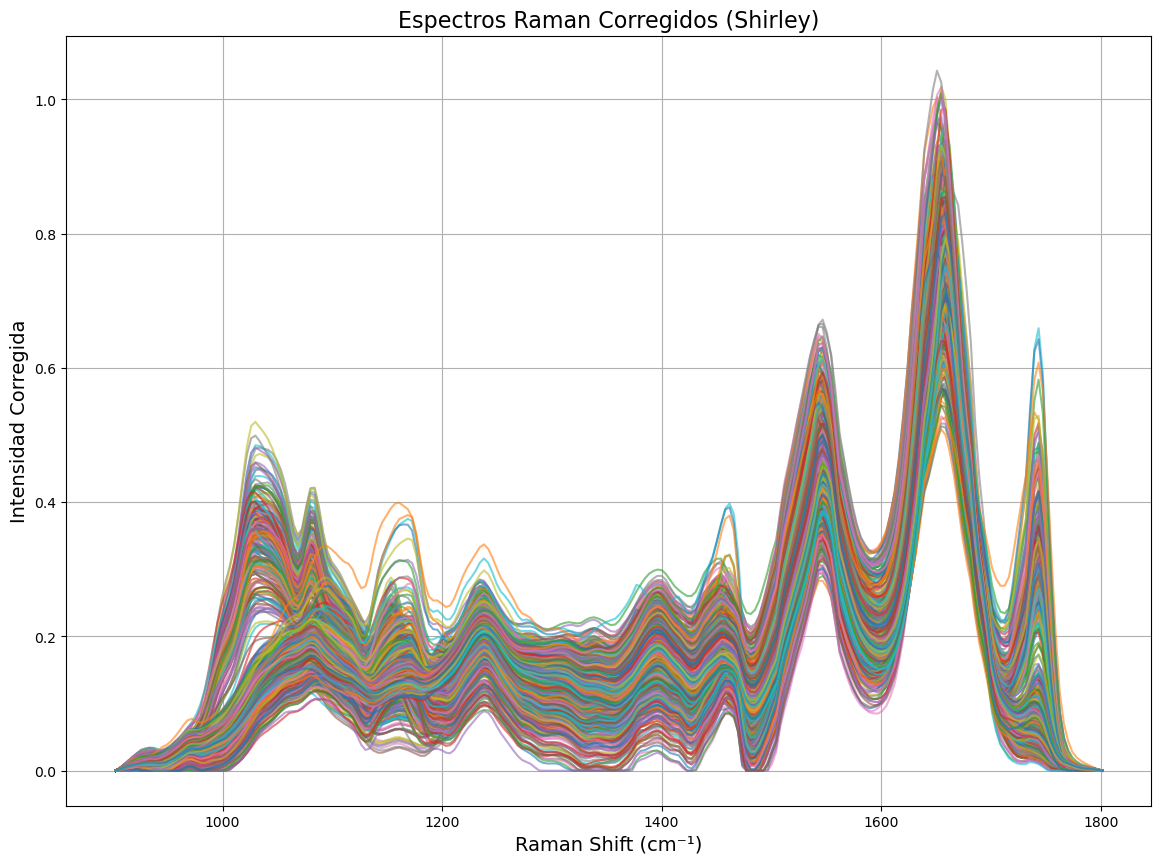

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

def shirley_correction(raman_shift, intensity):
    """
    Aplica la corrección de Shirley para un espectro.

    Parameters:
        raman_shift (array-like): Valores del eje X (Raman Shift).
        intensity (array-like): Intensidades del espectro (eje Y).

    Returns:
        corrected_intensity (array-like): Intensidades corregidas.
    """
    if len(raman_shift) != len(intensity):
        raise ValueError("La longitud de 'Ramanshift' y la intensidad no coincide.")

    corrected_intensity = intensity.copy()
    start = corrected_intensity[0]
    end = corrected_intensity[-1]

    for _ in range(100):  # Máximo 100 iteraciones
        background = start + (end - start) * np.cumsum(corrected_intensity) / np.sum(corrected_intensity)
        corrected_intensity = intensity - background
        corrected_intensity[corrected_intensity < 0] = 0  # Evitar valores negativos

    return corrected_intensity

# Cargar el archivo CSV
file_path = "limpio.csv"  # Ajusta la ruta según sea necesario
df = pd.read_csv(file_path)

# Extraer Raman Shift
raman_shift = df['Ramanshift'].values

# Identificar categorías de manera dinámica
column_names = df.columns[1:]
categories = {}

for col in column_names:
    match = re.match(r"([a-zA-Z]+)", col)  # Extraer solo las letras al inicio
    if match:
        category = match.group(1)
        if category not in categories:
            categories[category] = []
        categories[category].append(col)
    else:
        if "other" not in categories:
            categories["other"] = []
        categories["other"].append(col)

# Aplicar corrección de Shirley y almacenar datos corregidos
corrected_spectra = {}
for category, cols in categories.items():
    for col in cols:
        intensity = df[col].values
        corrected_spectra[col] = shirley_correction(raman_shift, intensity)

# Convertir a DataFrame
df_corrected = pd.DataFrame(corrected_spectra)
df_corrected.insert(0, 'Ramanshift', raman_shift)

# Asignar colores dinámicamente usando la nueva sintaxis de Matplotlib
unique_categories = list(categories.keys())
color_map = plt.colormaps.get_cmap("tab20")
category_colors = {category: color_map(i) for i, category in enumerate(unique_categories)}

# Graficar con colores por tipo detectado
plt.figure(figsize=(14, 10))

for category, cols in categories.items():
    for col in cols:
        plt.plot(df_corrected['Ramanshift'], df_corrected[col], alpha=0.6, 
                 label=category if col == cols[0] else "", color=category_colors[category])

plt.title("Espectros Raman Corregidos (Shirley)", fontsize=16)
plt.xlabel("Raman Shift (cm⁻¹)", fontsize=14)
plt.ylabel("Intensidad Corregida", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()